# Case Studies: Case Study 2

This example shows how we obtained the results in the paper
for the second case study. Let us load in the package we will need.

In [1]:
using StepwiseEQL
using CairoMakie
using EpithelialDynamics1D
using OrdinaryDiffEq
using Setfield
using LinearSolve

## Simulating
Let us start by simulating the cell dynamics. We use the force law $F(\ell) = k(s - \ell)$ as
usual.

In [2]:
k, η, s = 50.0, 1.0, 1 / 5
force_law = (δ, p) -> p.k * (p.s - δ)
force_law_parameters = (k=k, s=s)
initial_condition = LinRange(0, 5, 60) |> collect
prob = CellProblem(;
    force_law,
    force_law_parameters,
    final_time=100.0,
    damping_constant=η,
    initial_condition,
    fix_right=false)
sol = solve(prob, Tsit5(), saveat=LinRange(0, 100.0, 1000))

retcode: Success
Interpolation: 1st order linear
t: 1000-element Vector{Float64}:
   0.0
   0.10010010010010009
   0.20020020020020018
   0.3003003003003003
   0.40040040040040037
   0.5005005005005005
   0.6006006006006006
   0.7007007007007007
   0.8008008008008007
   0.9009009009009009
   ⋮
  99.1991991991992
  99.2992992992993
  99.3993993993994
  99.4994994994995
  99.5995995995996
  99.69969969969969
  99.7997997997998
  99.8998998998999
 100.0
u: 1000-element Vector{Vector{Float64}}:
 [0.0, 0.0847457627118644, 0.1694915254237288, 0.2542372881355932, 0.3389830508474576, 0.423728813559322, 0.5084745762711864, 0.5932203389830508, 0.6779661016949152, 0.7627118644067797  …  4.23728813559322, 4.322033898305085, 4.406779661016949, 4.491525423728814, 4.576271186440678, 4.661016949152542, 4.745762711864407, 4.830508474576271, 4.915254237288136, 5.0]
 [0.0, 0.08474576271186425, 0.1694915254237292, 0.25423728813559265, 0.33898305084745817, 0.42372881355932146, 0.508474576271187, 0.59322033

## Equation learning
We now define the equation learning problem. The mechanisms to learn are $D(q)$, $H(q)$, and
$E(q)$. The basis functions we use are:

In [3]:
diffusion_basis = PolynomialBasis(-1, -3)
rhs_basis = PolynomialBasis(1, 5)
moving_boundary_basis = PolynomialBasis(-1, -3)

(::BasisSet{Tuple{StepwiseEQL.var"#52#54"{Int64}, StepwiseEQL.var"#52#54"{Int64}, StepwiseEQL.var"#52#54"{Int64}}}) (generic function with 3 methods)

We now learn the equations. Our first attempt is below, where we use `initial=:none` so that we start
with no coefficients initially active.

In [4]:
eql_sol = stepwise_selection(sol; diffusion_basis, rhs_basis, moving_boundary_basis,
    mesh_points=500, initial=:none, threshold_tol=(q=0.35,))

StepwiseEQL Solution.
    D(q) = θ₃ᵈ ϕ₃ᵈ(q)
    H(q) = 0
    E(q) = 0
┌──────┬───────────────────┬──────────────────────────────┬──────────────────┬───────┐
│ Step │  θ₁ᵈ   θ₂ᵈ    θ₃ᵈ │  θ₁ʰ   θ₂ʰ   θ₃ʰ   θ₄ʰ   θ₅ʰ │  θ₁ᵉ   θ₂ᵉ   θ₃ᵉ │  Loss │
├──────┼───────────────────┼──────────────────────────────┼──────────────────┼───────┤
│    1 │ 0.00  0.00   0.00 │ 0.00  0.00  0.00  0.00  0.00 │ 0.00  0.00  0.00 │ -1.40 │
│    2 │ 0.00  0.00  25.06 │ 0.00  0.00  0.00  0.00  0.00 │ 0.00  0.00  0.00 │ -0.40 │
└──────┴───────────────────┴──────────────────────────────┴──────────────────┴───────┘


This result is clearly not perfect. To improve this, we limit the time range. We also
re-simulate the cell dynamics with a saving frequency.

In [5]:
sol = solve(prob, Tsit5(), saveat=15 // 199)
eql_sol = stepwise_selection(sol; diffusion_basis, rhs_basis, moving_boundary_basis,
    mesh_points=500, initial=:none, threshold_tol=(q=0.35,),
    time_range=(0.0, 15.0))

┌ Warning: Lower time bound of time_range is equal to the first time in cell_sol which is not allowed. Setting lower time bound to 0.07537688442211055, the second time.
└ @ StepwiseEQL \Users\User\Documents\Masters\EQL_Paper\StepwiseEQL\src\algorithm\run_stepwise.jl:42
LinearAlgebra.SingularException(0)


StepwiseEQL Solution.
    D(q) = θ₂ᵈ ϕ₂ᵈ(q)
    H(q) = θ₁ʰ ϕ₁ʰ(q) + θ₂ʰ ϕ₂ʰ(q)
    E(q) = θ₁ᵉ ϕ₁ᵉ(q)
┌──────┬───────────────────┬───────────────────────────────┬──────────────────┬───────┐
│ Step │  θ₁ᵈ    θ₂ᵈ   θ₃ᵈ │  θ₁ʰ    θ₂ʰ   θ₃ʰ   θ₄ʰ   θ₅ʰ │  θ₁ᵉ   θ₂ᵉ   θ₃ᵉ │  Loss │
├──────┼───────────────────┼───────────────────────────────┼──────────────────┼───────┤
│    1 │ 0.00   0.00  0.00 │ 0.00   0.00  0.00  0.00  0.00 │ 0.00  0.00  0.00 │ -3.37 │
│    2 │ 0.00   0.00  0.00 │ 0.00  -0.03  0.00  0.00  0.00 │ 0.00  0.00  0.00 │ -2.37 │
│    3 │ 0.00   0.00  0.00 │ 0.00  -0.03  0.00  0.00  0.00 │ 8.74  0.00  0.00 │ -3.68 │
│    4 │ 0.00  47.38  0.00 │ 0.00  -0.03  0.00  0.00  0.00 │ 8.74  0.00  0.00 │ -4.02 │
│    5 │ 0.00  47.38  0.00 │ 8.41  -1.69  0.00  0.00  0.00 │ 8.74  0.00  0.00 │ -8.14 │
└──────┴───────────────────┴───────────────────────────────┴──────────────────┴───────┘


These results have improved slightly. To plot them, we use the following function.

In [6]:
function plot_results(eql_sol, sol, k, s, η, diffusion_basis, rhs_basis, moving_boundary_basis, conserve_mass=false)
    t = (0, 5, 10, 25, 50, 100)
    prob = sol.prob.p
    prob = @set prob.final_time = 100.0
    sol = solve(prob, Tsit5(), saveat=[collect(t); LinRange(0, 100, 2500)] |> sort |> unique)
    time_indices = [findlast(≤(τ), sol.t) for τ in t]
    colors = (:black, :red, :blue, :green, :orange, :purple, :brown)

    pde = eql_sol.pde
    pde = @set pde.final_time = 100.0 # need to resolve so that we plot over the complete time interval
    pde_sol = solve(pde, TRBDF2(linsolve=KLUFactorization()), saveat=sol.t)
    pde_continuum = deepcopy(pde)
    pde_continuum.diffusion_parameters.θ .= [0, k / η, 0]
    pde_continuum.boundary_conditions.rhs.p.θ .= [0, 2.0, -2.0s, 0, 0]
    pde_continuum.boundary_conditions.moving_boundary.p.θ .= [0, k / η, 0]
    pde_ξ = pde_continuum.geometry.mesh_points
    pde_L = pde_sol[end, :]
    pde_q = pde_sol[begin:(end-1), :]
    cell_q = node_densities.(sol.u)
    cell_r = sol.u
    cell_L = sol[end, :]

    q_range = LinRange(5, 12, 250)

    fig = Figure(fontsize=45, resolution=(2220, 961))
    top_grid = fig[1, 1] = GridLayout(1, 2)
    bottom_grid = fig[2, 1] = GridLayout(1, 3)

    ax_pde = Axis(top_grid[1, 1], xlabel=L"x", ylabel=L"q(x,t)", width=950, height=300,
        title=L"(a):$ $ PDE comparison", titlealign=:left,
        xticks=(0:5:15, [L"%$s" for s in 0:5:15]), yticks=(0:5:15, [L"%$s" for s in 0:5:15]))
    for (j, i) in enumerate(time_indices)
        lines!(ax_pde, pde_ξ * pde_L[i], pde_q[:, i], color=colors[j], linestyle=:dash, linewidth=8)
        lines!(ax_pde, cell_r[i], cell_q[i], color=colors[j], linewidth=4, label=L"%$(t[j])")
    end
    arrows!(ax_pde, [6.0], [12.0], [4.0], [-3.0], color=:black, linewidth=8, arrowsize=40)
    text!(ax_pde, [8.0], [11.0], text=L"t", color=:black, fontsize=63)
    xlims!(ax_pde, 0, 15)
    ylims!(ax_pde, 4, 16)

    ax_leading_edge = Axis(top_grid[1, 2], xlabel=L"t", ylabel=L"L(t)", width=950, height=300,
        title=L"(b):$ $ Leading edge comparison", titlealign=:left,
        xticks=(0:10:100, [L"%$s" for s in 0:10:100]), yticks=(0:5:15, [L"%$s" for s in 0:5:15]))
    lines!(ax_leading_edge, pde_sol.t, pde_L, color=:red, linestyle=:dash, linewidth=5, label=L"$ $Learned")
    lines!(ax_leading_edge, sol.t, cell_L, color=:black, linewidth=3, label=L"$ $Discrete")
    axislegend(position=:rb)
    xlims!(ax_leading_edge, 0, 100)
    ylims!(ax_leading_edge, 0, 15)

    ax_diffusion = Axis(bottom_grid[1, 1],
        xlabel=L"q", ylabel=L"D(q)", width=600, height=300,
        title=L"(c): $D(q)$ comparison", titlealign=:left,
        xticks=(5:3:12, [L"%$s" for s in 5:3:12]), yticks=(0:5, [L"%$s" for s in 0:5]))
    D_cont_fnc = q -> (k / η) / q^2
    D_cont = D_cont_fnc.(q_range)
    local D_sol
    try
        D_sol = diffusion_basis.(q_range, Ref(eql_sol.diffusion_theta), Ref(nothing))
    catch e
        print(e)
        D_sol = D_cont
    end
    lines!(ax_diffusion, q_range, D_sol, linewidth=6, color=:red, linestyle=:solid, label=L"$ $Learned")
    lines!(ax_diffusion, q_range, D_cont, linewidth=6, color=:black, linestyle=:dashdot, label=L"$ $Continuum limit")
    axislegend(position=:rt)
    xlims!(ax_diffusion, 5, 12)
    ylims!(ax_diffusion, 0, 5)

    ax_rhs = Axis(bottom_grid[1, 2],
        xlabel=L"q", ylabel=L"H(q)", width=600, height=300,
        title=L"(d): $H(q)$ comparison", titlealign=:left,
        xticks=(5:3:12, [L"%$s" for s in 5:3:12]), yticks=(-100:40:20, [L"%$s" for s in -100:40:20]))
    RHS_cont_fnc = q -> 2q^2 * (1 - s * q)
    RHS_cont = RHS_cont_fnc.(q_range)
    local RHS_sol
    try
        RHS_sol = rhs_basis.(q_range, Ref(eql_sol.rhs_theta), Ref(nothing))
    catch e
        print(e)
        RHS_sol = RHS_cont
    end
    lines!(ax_rhs, q_range, RHS_sol, linewidth=6, color=:red, linestyle=:solid, label=L"$ $Learned")
    lines!(ax_rhs, q_range, RHS_cont, linewidth=6, color=:black, linestyle=:dashdot, label=L"$ $Continuum limit")
    axislegend(position=:rt)
    xlims!(ax_rhs, 5, 12)
    ylims!(ax_rhs, -100, 20)

    ax_moving_boundary = Axis(bottom_grid[1, 3],
        xlabel=L"q", ylabel=L"E(q)", width=600, height=300,
        title=L"(e): $E(q)$ comparison", titlealign=:left,
        xticks=(5:3:12, [L"%$s" for s in 5:3:12]), yticks=(0:5, [L"%$s" for s in 0:5]))
    MB_cont_fnc = q -> (k / η) / q^2
    MB_cont = MB_cont_fnc.(q_range)
    local MB_sol
    try
        if !conserve_mass
            MB_sol = moving_boundary_basis.(q_range, Ref(eql_sol.moving_boundary_theta), Ref(nothing))
        else
            MB_sol = moving_boundary_basis.(q_range, Ref(eql_sol.diffusion_theta), Ref(nothing))
        end
    catch e
        print(e)
        MB_sol = MB_cont
    end
    lines!(ax_moving_boundary, q_range, MB_sol, linewidth=6, color=:red, linestyle=:solid, label=L"$ $Learned")
    lines!(ax_moving_boundary, q_range, MB_cont, linewidth=6, color=:black, linestyle=:dashdot, label=L"$ $Continuum limit")
    axislegend(position=:rt)
    xlims!(ax_moving_boundary, 5, 12)
    ylims!(ax_moving_boundary, 0, 5)
    fig
end;

Using this function, we obtain the plot below.

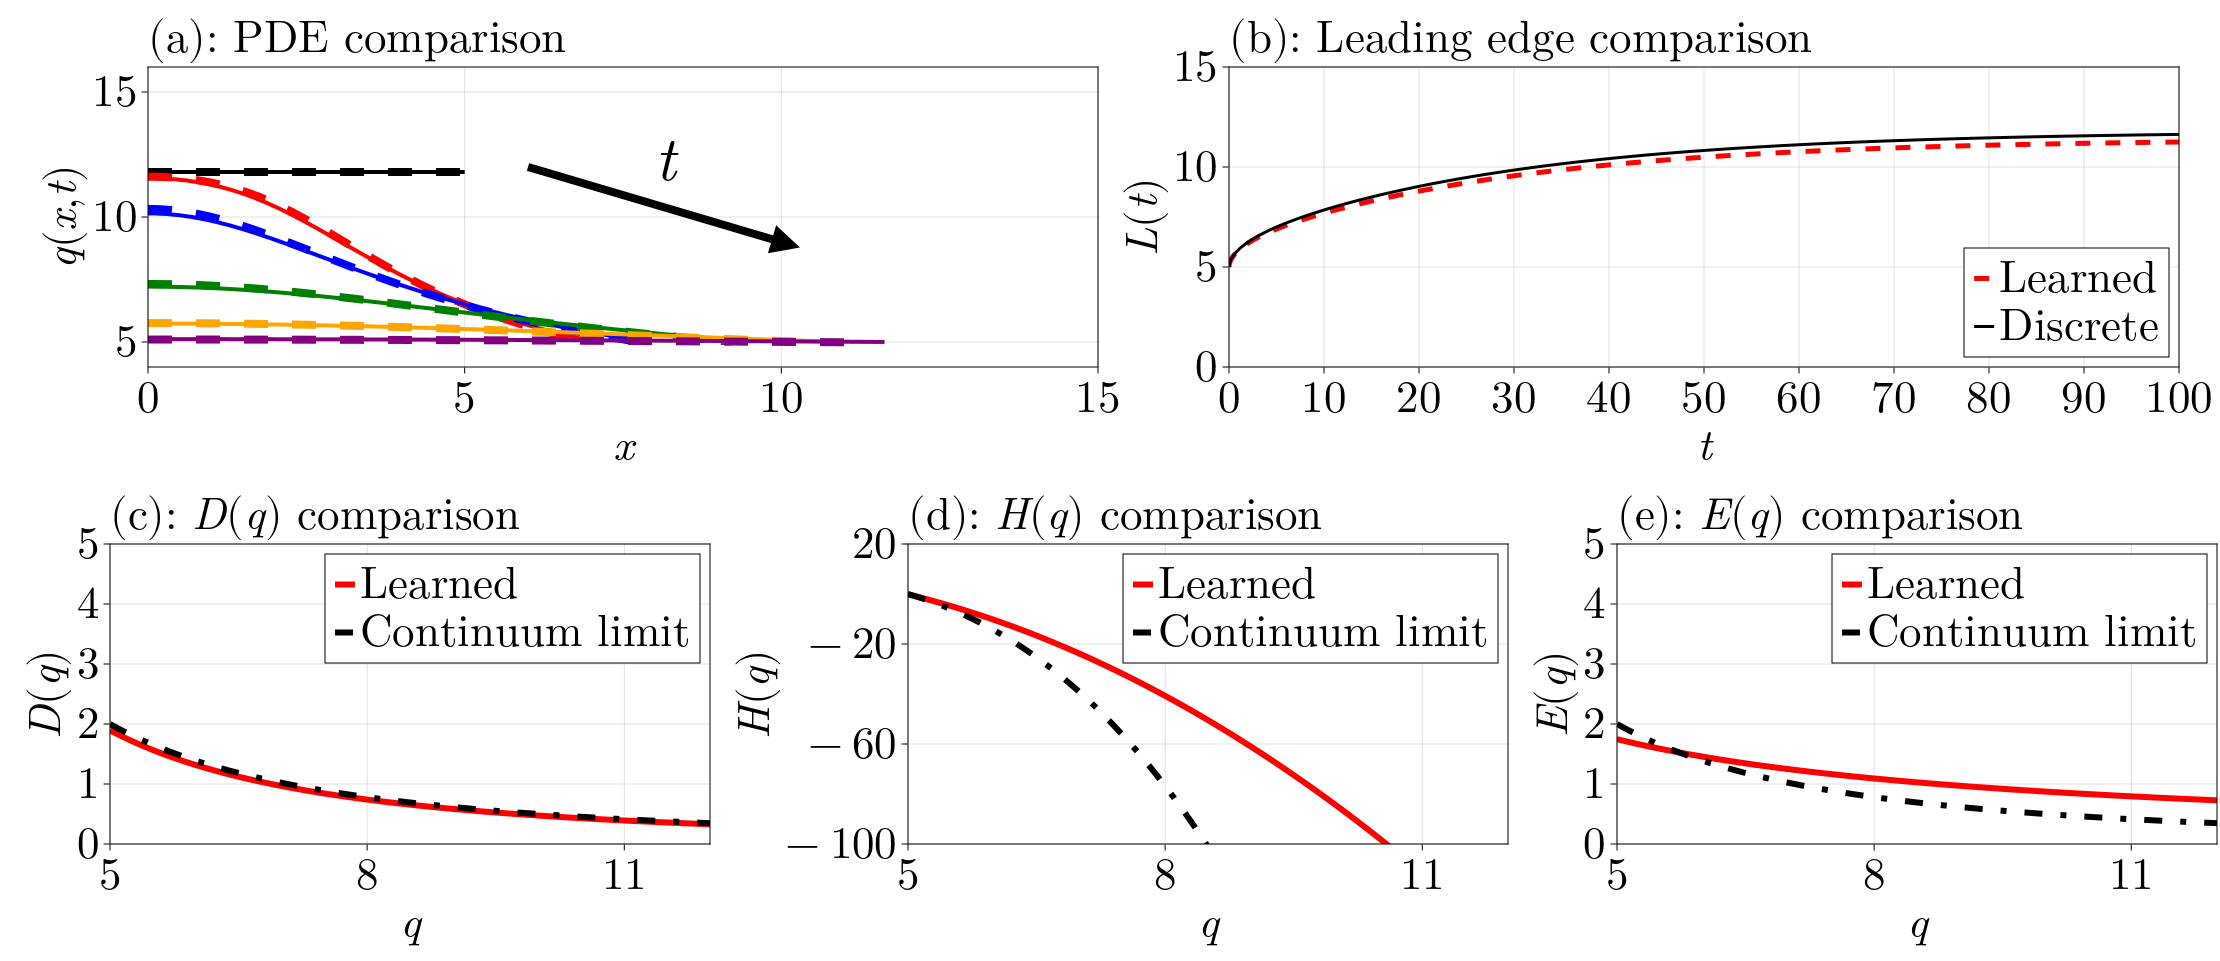

In [7]:
fig = plot_results(eql_sol, sol, k, s, η, diffusion_basis, rhs_basis, moving_boundary_basis)

Since the leading edges start to diverge for late time, we need to prune the matrix slightly.
We do this as follows, giving our improved results.

In [8]:
eql_sol = stepwise_selection(sol; diffusion_basis, rhs_basis, moving_boundary_basis,
    mesh_points=500, initial=:none, threshold_tol=(q=0.35, dL=0.1),
    time_range=(0.0, 15.0))

┌ Warning: Lower time bound of time_range is equal to the first time in cell_sol which is not allowed. Setting lower time bound to 0.07537688442211055, the second time.
└ @ StepwiseEQL \Users\User\Documents\Masters\EQL_Paper\StepwiseEQL\src\algorithm\run_stepwise.jl:42


StepwiseEQL Solution.
    D(q) = θ₂ᵈ ϕ₂ᵈ(q)
    H(q) = θ₁ʰ ϕ₁ʰ(q) + θ₂ʰ ϕ₂ʰ(q)
    E(q) = θ₁ᵉ ϕ₁ᵉ(q)
┌──────┬───────────────────┬───────────────────────────────┬──────────────────┬────────┐
│ Step │  θ₁ᵈ    θ₂ᵈ   θ₃ᵈ │  θ₁ʰ    θ₂ʰ   θ₃ʰ   θ₄ʰ   θ₅ʰ │  θ₁ᵉ   θ₂ᵉ   θ₃ᵉ │   Loss │
├──────┼───────────────────┼───────────────────────────────┼──────────────────┼────────┤
│    1 │ 0.00   0.00  0.00 │ 0.00   0.00  0.00  0.00  0.00 │ 0.00  0.00  0.00 │  -3.37 │
│    2 │ 0.00   0.00  0.00 │ 0.00  -0.03  0.00  0.00  0.00 │ 0.00  0.00  0.00 │  -2.37 │
│    3 │ 0.00   0.00  0.00 │ 0.00  -0.03  0.00  0.00  0.00 │ 9.42  0.00  0.00 │  -3.93 │
│    4 │ 0.00  47.38  0.00 │ 0.00  -0.03  0.00  0.00  0.00 │ 9.42  0.00  0.00 │  -4.41 │
│    5 │ 0.00  47.38  0.00 │ 8.41  -1.69  0.00  0.00  0.00 │ 9.42  0.00  0.00 │ -12.23 │
└──────┴───────────────────┴───────────────────────────────┴──────────────────┴────────┘


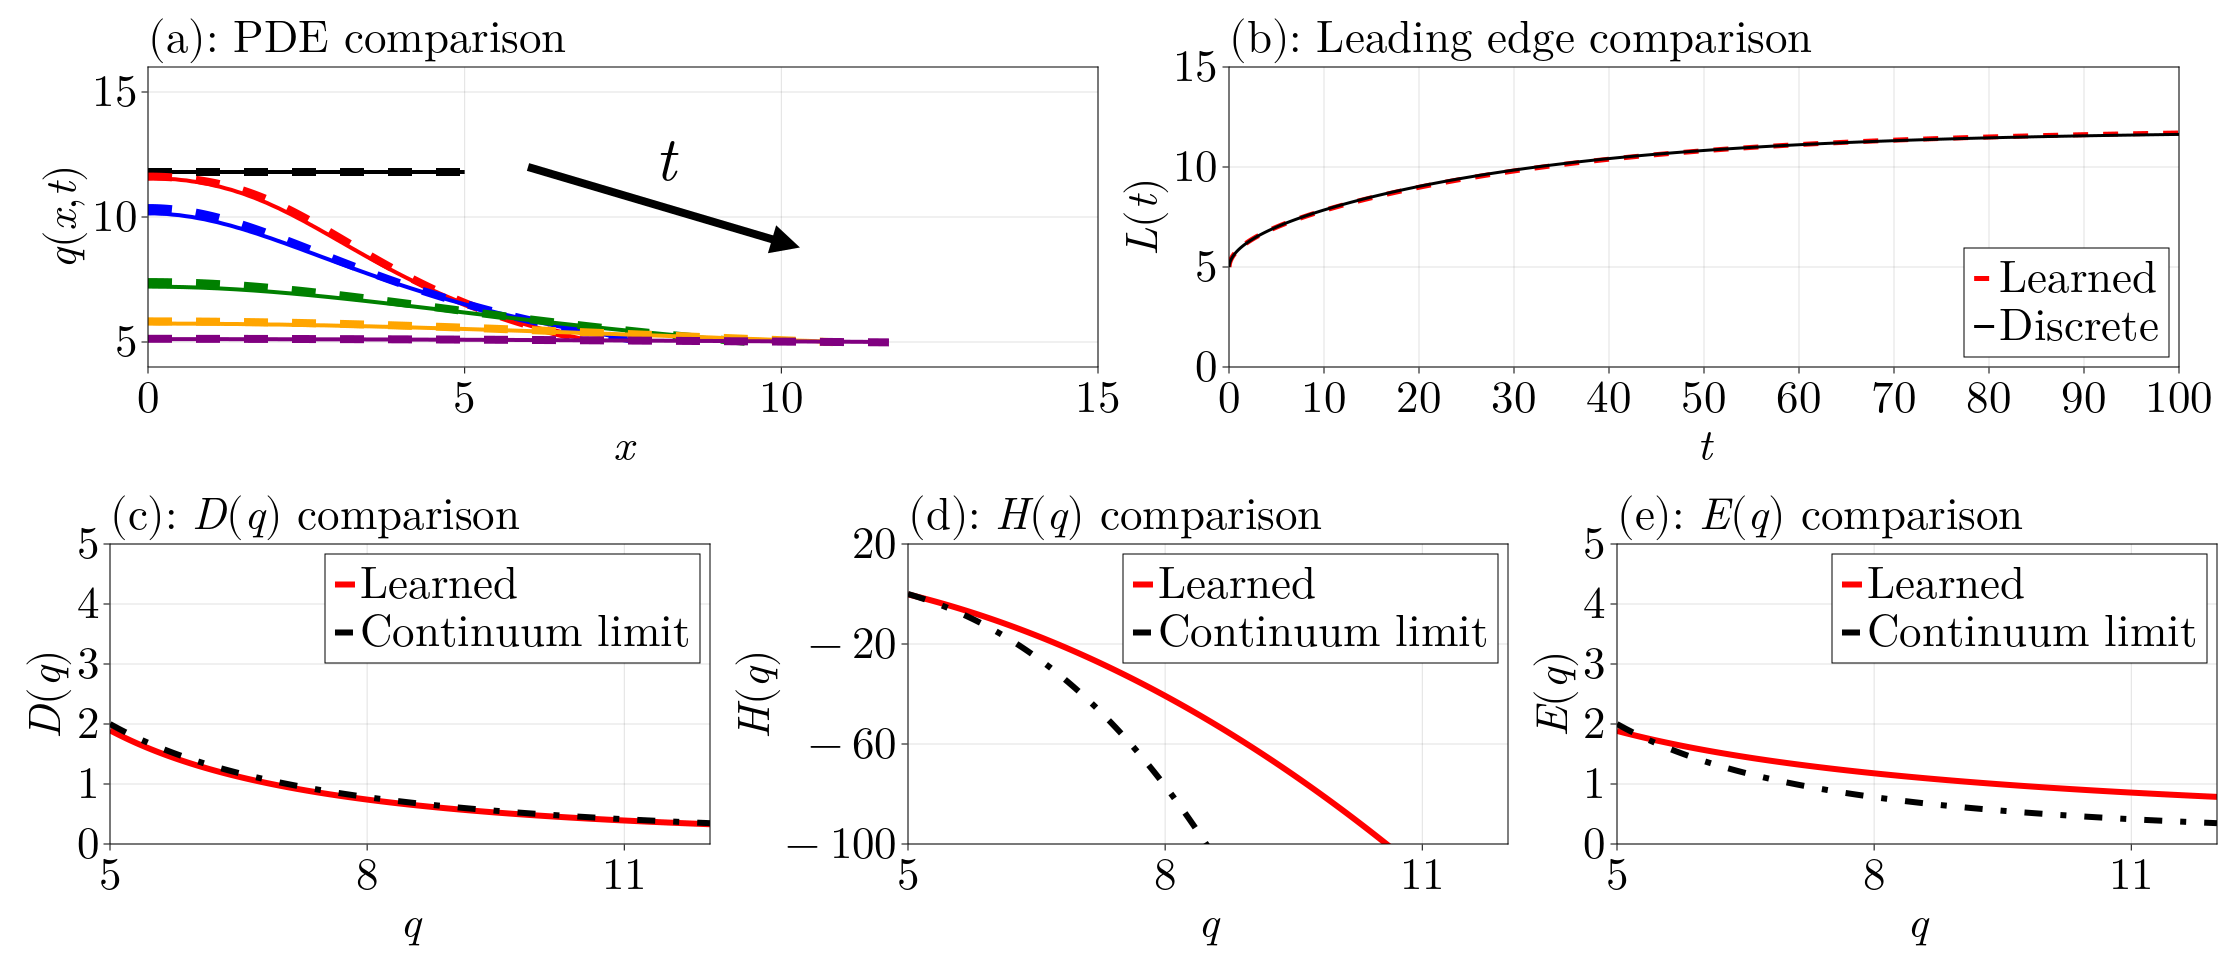

In [9]:
fig = plot_results(eql_sol, sol, k, s, η, diffusion_basis, rhs_basis, moving_boundary_basis)

## Conservation of mass
If we want to enforce conservation of mass, we can set $D(q) = E(q)$ by simply using
the keyword argument `conserve_mass=true` as below. These are the results that we
describe in more detail in the supplementary material of our paper.

In [10]:
eql_sol = stepwise_selection(sol; diffusion_basis, rhs_basis, moving_boundary_basis,
    mesh_points=500, initial=:none, threshold_tol=(q=0.35, dL=0.1),
    time_range=(0.0, 15.0), conserve_mass=true)

┌ Warning: Lower time bound of time_range is equal to the first time in cell_sol which is not allowed. Setting lower time bound to 0.07537688442211055, the second time.
└ @ StepwiseEQL \Users\User\Documents\Masters\EQL_Paper\StepwiseEQL\src\algorithm\run_stepwise.jl:42


StepwiseEQL Solution.
    D(q) = θ₂ᵈ ϕ₂ᵈ(q)
    H(q) = θ₂ʰ ϕ₂ʰ(q) + θ₅ʰ ϕ₅ʰ(q)
┌──────┬───────────────────┬────────────────────────────────┬────────┐
│ Step │  θ₁ᵈ    θ₂ᵈ   θ₃ᵈ │  θ₁ʰ    θ₂ʰ   θ₃ʰ   θ₄ʰ    θ₅ʰ │   Loss │
├──────┼───────────────────┼────────────────────────────────┼────────┤
│    1 │ 0.00   0.00  0.00 │ 0.00   0.00  0.00  0.00   0.00 │  -3.37 │
│    2 │ 0.00   0.00  0.00 │ 0.00  -0.03  0.00  0.00   0.00 │  -2.37 │
│    3 │ 0.00  47.41  0.00 │ 0.00  -0.03  0.00  0.00   0.00 │  -3.85 │
│    4 │ 0.00  47.41  0.00 │ 0.00   0.44  0.00  0.00  -0.00 │ -10.64 │
└──────┴───────────────────┴────────────────────────────────┴────────┘


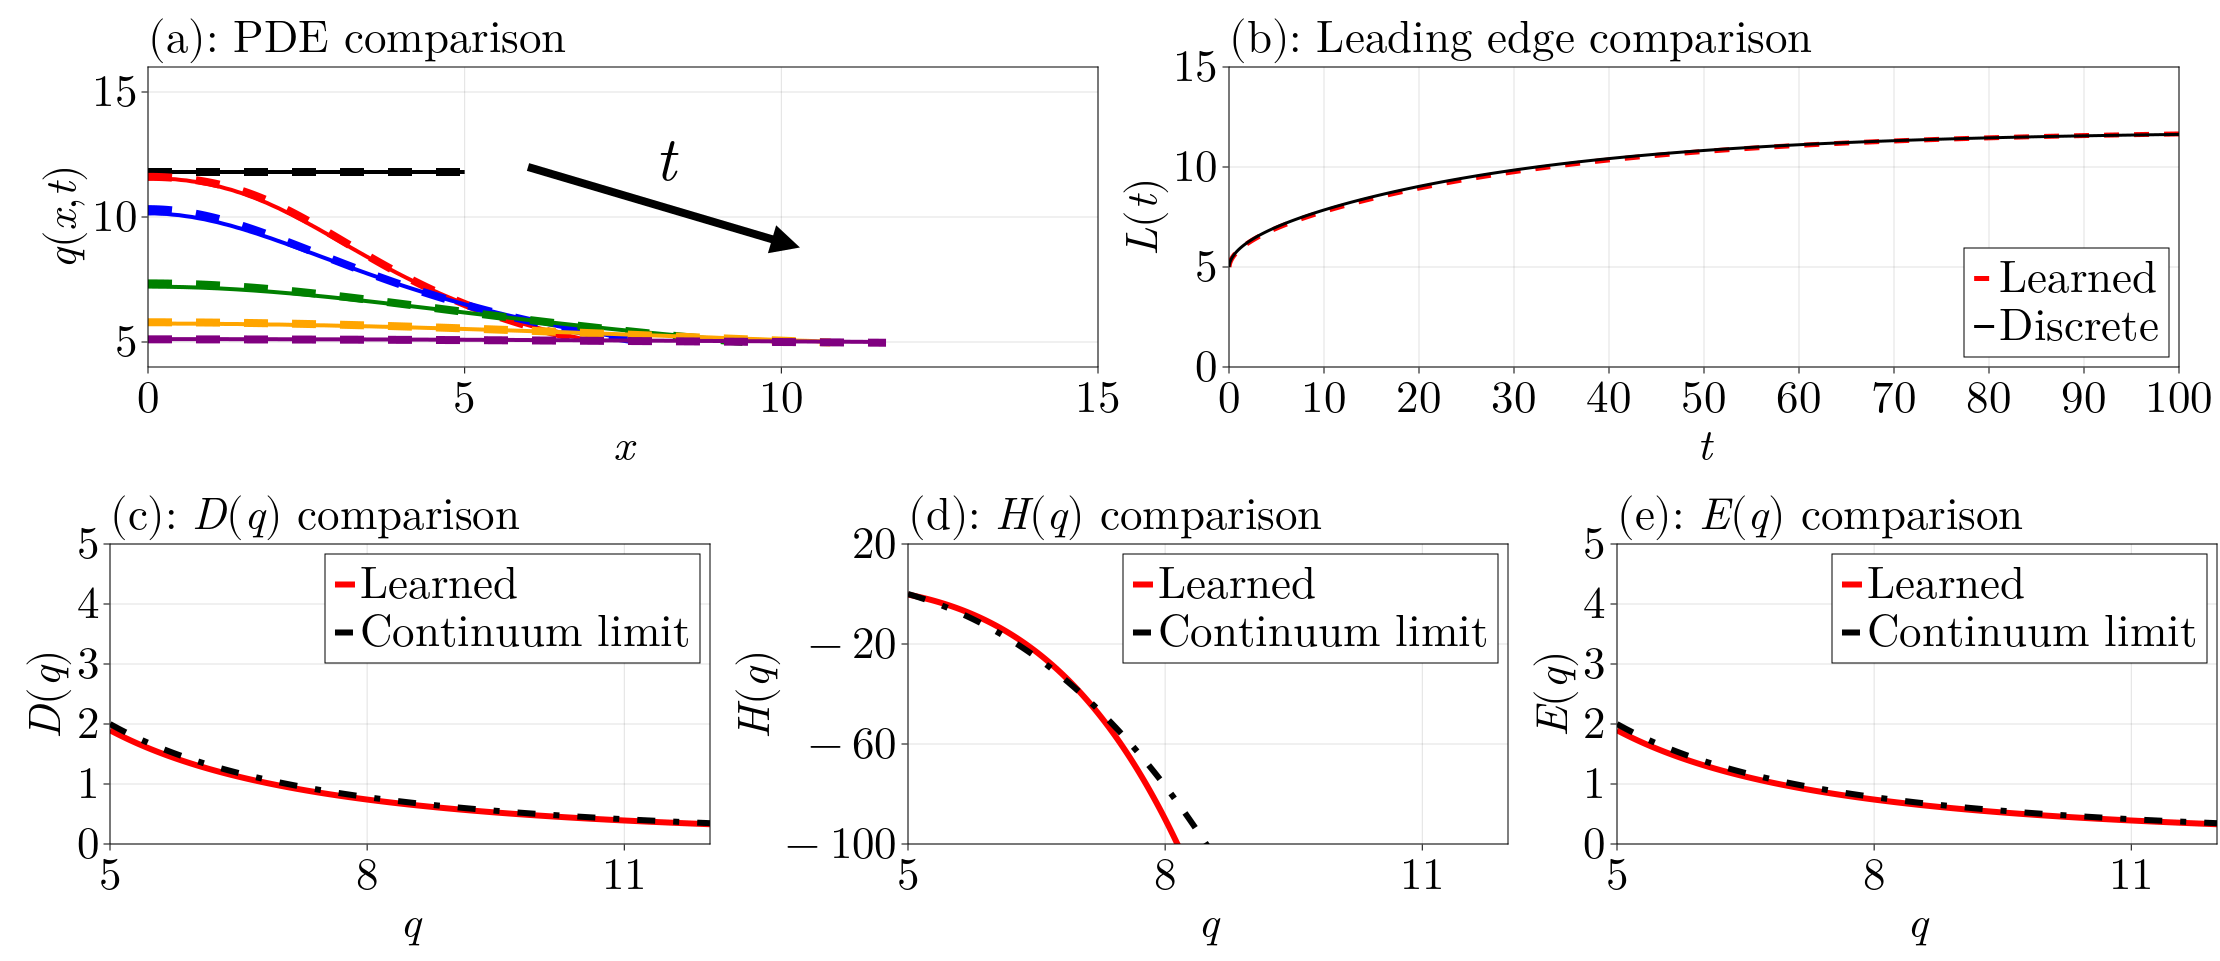

In [11]:
fig = plot_results(eql_sol, sol, k, s, η, diffusion_basis, rhs_basis, moving_boundary_basis, true)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*